# Kubeflow Pipelines e2e mnist example (in KFPv2 syntax)

**Note**: KFPv2 is currently in Alpha phase, the syntax and usage below are subject to change.

In this notebook you will create e2e mnist Kubeflow Pipeline to perform:
- Hyperparameter tuning using Katib
- Distributive training with the best hyperparameters using TFJob
- Serve the trained model using KServe

We use KFPv2 syntax to define pipeline template, for detail about KFPv2, refer to:

- [KFPv2 documentation](https://www.kubeflow.org/docs/components/pipelines/v2/)

Reference documentation:

- https://www.kubeflow.org/docs/components/training/tftraining/
- https://www.kubeflow.org/docs/components/katib/
- https://www.kubeflow.org/docs/external-add-ons/kserve/

**Note**: This Pipeline runs in the multi-user mode. Follow [full Kubeflow connection guide](https://www.kubeflow.org/docs/components/pipelines/v1/sdk/connect-api/) to give your Notebook access to Kubeflow Pipelines.

**Note**: Due to [issue #8300](https://github.com/kubeflow/pipelines/issues/8300), connecting to Kubeflow Pipelines using PodDefaults is not working for now. You can still use the Kubeflow Dashboard to upload pipeline and create run.

In [ ]:
# Install required packages (Kubeflow Pipelines and Katib SDK).
!python3 -m pip install --no-cache-dir --force-reinstall --pre kfp
!pip install kubeflow-katib==0.12.0

In [ ]:
# Make sure KFP SDK version is at least 2.0.0-beta.4
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

## Create Persistent Volume Claim to store Model

[dsl.VolumeOp](https://kubeflow-pipelines.readthedocs.io/en/latest/_modules/kfp/dsl/_volume_op.html) is currently not available in KFPv2. For now, you can create Persistent Volume Claim using `kubectl` from commandline. In this example, we assume your project is `kubeflow-user-project`, make sure you have access to namespace `kubeflow-user-project` in `kubectl` kubeconfig. 

**Note**: Run the following command in your terminal, replace `<kubeflow-user-project>` with your Kubeflow project name:

```
cat <<EOF | kubectl create -f -
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: 'workflow1-model-volume'
  namespace: '<kubeflow-user-project>'
spec:
  accessModes:
  - ReadWriteOnce
  resources:
    requests:
      storage: 1Gi
EOF
```

## Define the Pipelines tasks

To run this Pipeline, you should define:
1. Katib hyperparameter tuning
2. TFJob training
3. KServe inference



### Import necessary modules

In [ ]:
import kfp
import kfp.dsl as dsl
from kfp import components
from kfp.dsl import Output, Artifact

from kubeflow.katib import ApiClient
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

from typing import Dict, List, NamedTuple

### Step 1. Katib hyperparameter tuning task

Create the Kubeflow Pipelines task for the Katib hyperparameter tuning. This Experiment uses "random" algorithm and TFJob for the Trial's worker.

The Katib Experiment is similar to this example: https://github.com/kubeflow/katib/blob/master/examples/v1beta1/kubeflow-training-operator/tfjob-mnist-with-summaries.yaml.

In [ ]:
# You should define the Experiment name, namespace and number of training steps in the arguments.
@dsl.component(
    base_image='python:3.8',
    packages_to_install=['kubeflow-katib==0.12.0']
)
def create_katib_experiment_task(experiment_name: str, experiment_namespace: str, training_steps: str
                                ) -> NamedTuple('Outputs', [('experiment_spec_json', Dict[str, str])]):
    
    from kubeflow.katib import ApiClient
    from kubeflow.katib import V1beta1ExperimentSpec
    from kubeflow.katib import V1beta1AlgorithmSpec
    from kubeflow.katib import V1beta1ObjectiveSpec
    from kubeflow.katib import V1beta1ParameterSpec
    from kubeflow.katib import V1beta1FeasibleSpace
    from kubeflow.katib import V1beta1TrialTemplate
    from kubeflow.katib import V1beta1TrialParameterSpec
    
    # Trial count specification.
    max_trial_count = 5
    max_failed_trial_count = 3
    parallel_trial_count = 2

    # Objective specification.
    objective = V1beta1ObjectiveSpec(
        type="minimize",
        goal=0.001,
        objective_metric_name="loss"
    )

    # Algorithm specification.
    algorithm = V1beta1AlgorithmSpec(
        algorithm_name="random",
    )

    # Experiment search space.
    # In this example we tune learning rate and batch size.
    parameters = [
        V1beta1ParameterSpec(
            name="learning_rate",
            parameter_type="double",
            feasible_space=V1beta1FeasibleSpace(
                min="0.01",
                max="0.05"
            ),
        ),
        V1beta1ParameterSpec(
            name="batch_size",
            parameter_type="int",
            feasible_space=V1beta1FeasibleSpace(
                min="80",
                max="100"
            ),
        )
    ]

    # Experiment Trial template.
    # TODO (andreyvelich): Use community image for the mnist example.
    trial_spec = {
        "apiVersion": "kubeflow.org/v1",
        "kind": "TFJob",
        "spec": {
            "tfReplicaSpecs": {
                "Chief": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                },
                "Worker": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                }
            }
        }
    }

    # Configure parameters for the Trial template.
    trial_template = V1beta1TrialTemplate(
        primary_container_name="tensorflow",
        trial_parameters=[
            V1beta1TrialParameterSpec(
                name="learningRate",
                description="Learning rate for the training model",
                reference="learning_rate"
            ),
            V1beta1TrialParameterSpec(
                name="batchSize",
                description="Batch size for the model",
                reference="batch_size"
            ),
        ],
        trial_spec=trial_spec
    )

    # Create an Experiment from the above parameters.
    experiment_spec = V1beta1ExperimentSpec(
        max_trial_count=max_trial_count,
        max_failed_trial_count=max_failed_trial_count,
        parallel_trial_count=parallel_trial_count,
        objective=objective,
        algorithm=algorithm,
        parameters=parameters,
        trial_template=trial_template
    )
     
    # Convert experiment_spec to Dict type.
    experiment_spec_json = ApiClient().sanitize_for_serialization(experiment_spec)
    output = NamedTuple('Outputs', [('experiment_spec_json', Dict[str, str])])
    return output(experiment_spec_json)
    

In [ ]:
@dsl.component
def convert_experiment_spec_to_str(experiment_spec_json: Dict[str, str])-> NamedTuple('Outputs', [('experiment_spec_str_output', str)]):
    import json
    output = NamedTuple('Outputs', [('experiment_spec_str_output', str)])
    return output(json.dumps(experiment_spec_json))

In [ ]:
# This container component is katib launcher, its API is same as the following yaml file in KFPv1.
# https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml
from kfp.dsl import Input, Output, Artifact, container_component, ContainerSpec

@dsl.container_component
def create_dataset(experiment_name: str, experiment_namespace: str, experiment_timeout_minutes: int, 
                   experiment_spec_json: str, parameter_set: Output[Artifact]):
    return ContainerSpec(
        image='docker.io/kubeflowkatib/kubeflow-pipelines-launcher',
        command=['python', 'src/launch_experiment.py'],
        args=[
          '--experiment-name',           experiment_name,
          '--experiment-namespace',      experiment_namespace,
          '--experiment-spec',           experiment_spec_json,
          '--experiment-timeout-minutes',experiment_timeout_minutes,
          '--delete-after-done',         'False',
          '--output-file',               parameter_set.path,
        ])

### Step 2. TFJob training task

Create the Kubeflow Pipelines task for the TFJob training. In this example TFJob runs the Chief and Worker with 1 replica.

Learn more about TFJob replica specifications in the Kubeflow docs: https://www.kubeflow.org/docs/components/training/tftraining/#what-is-tfjob.

In [ ]:
# This function converts Katib Experiment HP results to args.
@dsl.component
def convert_katib_results(katib_results: Input[Artifact]) -> str:
    import json
    import pprint
    katib_results_str = ''
    with open(katib_results.path, 'r') as f:
        katib_results_str = f.read()
    katib_results_json = json.loads(katib_results_str)
    print("Katib results:")
    pprint.pprint(katib_results_json)
    best_hps = []
    for pa in katib_results_json["currentOptimalTrial"]["parameterAssignments"]:
        if pa["name"] == "learning_rate":
            best_hps.append("--tf-learning-rate=" + pa["value"])
        elif pa["name"] == "batch_size":
            best_hps.append("--tf-batch-size=" + pa["value"])
    print("Best Hyperparameters: {}".format(best_hps))
    return " ".join(best_hps)

In [ ]:
# You should define the TFJob name, namespace, number of training steps, output of Katib and model volume tasks in the arguments.
@dsl.component
def create_tfjob_task(tfjob_name: str, tfjob_namespace: str, training_steps: str, best_hps: str, model_volume_name: str,
                     ) -> NamedTuple('Outputs', [('chief_spec', Dict[str, str]), ('worker_spec', Dict[str, str])]):
    # Get parameters from the Katib Experiment.
    # Parameters are in the format "--tf-learning-rate=0.01 --tf-batch-size=100"

    # Create the TFJob Chief and Worker specification with the best Hyperparameters.
    # TODO (andreyvelich): Use community image for the mnist example.
    tfjob_chief_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c"
                        ],
                        "args": [
                            "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps)
                        ],
                        "volumeMounts": [
                            {
                                "mountPath": "/mnt/export",
                                "name": "model-volume"
                            }
                        ]
                    }
                ],
                "volumes": [
                    {
                        "name": "model-volume",
                        "persistentVolumeClaim": {
                            "claimName": model_volume_name
                        }
                    }
                ]
            }
        }
    }

    tfjob_worker_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c",
                        ],
                        "args": [
                          "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps) 
                        ],
                    }
                ],
            }
        }
    }
        
    output = NamedTuple('Outputs', [('chief_spec', Dict[str, str]), ('worker_spec', Dict[str, str])])
    return output(tfjob_chief_spec, tfjob_worker_spec)
    

In [ ]:
# This container component is TFJob launcher, its API is same as the following yaml file in KFPv1.
# https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/launcher/component.yaml
from kfp.dsl import Input, Output, Artifact, container_component, ContainerSpec

@dsl.container_component
def tfjob_launcher(tfjob_name: str, tfjob_namespace: str,
                   worker_spec: Dict[str, str],
                   chief_spec: Dict[str, str],
                   tfjob_timeout_minutes: int):
    return ContainerSpec(
        image='nikenano/launchernew:latest',
        command=['python', '/ml/launch_tfjob.py'],
        args=[
          '--name',                     tfjob_name,
          '--namespace',                tfjob_namespace,
          '--workerSpec',               worker_spec,
          '--chiefSpec',                chief_spec,
          '--tfjobTimeoutMinutes',      tfjob_timeout_minutes,
          '--deleteAfterDone',          'False',
        ])

### Step 3. KServe inference

Create the Kubeflow Pipelines task for the KServe inference.

In [ ]:
@dsl.component
def create_serving_task(model_name: str, model_namespace: str, model_volume_name: str
                       ) -> NamedTuple('Outputs', [('inferenceservice_yaml', Dict[str, str])]):

    api_version = 'serving.kserve.io/v1beta1'
    inference_service = {
        "apiVersion": api_version,
        "kind": "InferenceService",
        "metadata": {
          "name": model_name,
          "namespace": model_namespace,
          "annotations": {
            "sidecar.istio.io/inject": "false"
          }
        },
        "spec":{
          "predictor":{
            "tensorflow": {
              "storageUri": "pvc://{}/".format(model_volume_name)
            }
          }
        }
    }

    output = NamedTuple('Outputs', [('inferenceservice_yaml', Dict[str, str])])
    return output(inference_service)

In [ ]:
# This container component is KServe launcher, its API is same as the following yaml file in KFPv1.
# https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kserve/component.yaml
from kfp.dsl import Input, Output, Artifact, container_component, ContainerSpec

@dsl.container_component
def serving_launcher(action: str, inferenceservice_yaml: Dict[str, str]):
    return ContainerSpec(
        image='quay.io/aipipeline/kserve-component:v0.7.0',
        command=['python', 'kservedeployer.py' ],
        args=[
          '--action',                 action,
          '--inferenceservice-yaml',  inferenceservice_yaml,
        ])

In [ ]:
@dsl.component
def convert_inference_service_to_artifact(inferenceservice_yaml: Dict[str, str], inferenceservice_artifact: Output[Artifact]):
    import json
    with open(inferenceservice_artifact.path, 'w') as f:
        f.write(json.dumps(inferenceservice_yaml))

In [ ]:
@dsl.pipeline
def serving_pipeline(model_name: str, model_namespace: str, model_volume_name: str)    -> Artifact:
    create_serving_task_op = create_serving_task(model_name=model_name, model_namespace=model_namespace, model_volume_name=model_volume_name)
    convert_inference_service_to_artifact_op = convert_inference_service_to_artifact(
        inferenceservice_yaml=create_serving_task_op.outputs['inferenceservice_yaml'])
    serving_launcher_op = serving_launcher(
        action='apply', 
        inferenceservice_yaml=create_serving_task_op.outputs['inferenceservice_yaml']
    ).after(convert_inference_service_to_artifact_op)
    
    return convert_inference_service_to_artifact_op.outputs['inferenceservice_artifact']

## Run the Kubeflow Pipeline

You should create the Kubeflow Pipeline from the above tasks.

In [ ]:
name="mnist-e2e"
namespace="kubeflow-user-project"
training_steps="200"
model_volume_name="workflow1-model-volume"


@dsl.pipeline(
    name="End to End Pipeline",
    description="An end to end mnist example including hyperparameter tuning, train and inference"
)
def mnist_pipeline(name: str =name, namespace: str = namespace, training_steps: str =training_steps, model_volume_name: str = model_volume_name):
    # Run the hyperparameter tuning with Katib.
    katib_op = create_katib_experiment_task(experiment_name=name, experiment_namespace=namespace, training_steps=training_steps)
    convert_experiment_spec_to_str_op = convert_experiment_spec_to_str(experiment_spec_json=katib_op.outputs['experiment_spec_json'])
    create_dataset_op = create_dataset(experiment_name=name, experiment_namespace=namespace, experiment_timeout_minutes=60,
                   experiment_spec_json=convert_experiment_spec_to_str_op.outputs['experiment_spec_str_output'])
    
    # Run the distributive training with TFJob.
    convert_katib_results_op = convert_katib_results(katib_results=create_dataset_op.outputs['parameter_set'])
    tfjob_op = create_tfjob_task(tfjob_name= name,
                                 tfjob_namespace=namespace,
                                 training_steps= training_steps, 
                                 best_hps=convert_katib_results_op.output,
                                 model_volume_name=model_volume_name)
    tfjob_launcher_op = tfjob_launcher(tfjob_name= name,
                                 tfjob_namespace=namespace,
                                 chief_spec=tfjob_op.outputs['chief_spec'],
                                 worker_spec=tfjob_op.outputs['worker_spec'],
                                 tfjob_timeout_minutes=60).after(convert_katib_results_op)

    # Create the KServe inference.
    serving_pipeline_op = serving_pipeline(model_name=name, model_namespace=namespace, model_volume_name=model_volume_name).after(tfjob_launcher_op)



In [ ]:
from kfp import compiler

OUTPUT_PACKAGE_PATH = 'mnist_pipeline.yaml'

compiler.Compiler().compile(
    pipeline_func=mnist_pipeline, 
    package_path=OUTPUT_PACKAGE_PATH,
)

In [ ]:
# Due to [issue #8300](https://github.com/kubeflow/pipelines/issues/8300), 
# connecting to Kubeflow Pipelines using PodDefaults is not working for now. You can still use the Kubeflow Dashboard to upload pipeline and create run.

# Run the Kubeflow Pipeline in the user's namespace.
# kfp_client=kfp.Client()
# run_id = kfp_client.create_run_from_pipeline_func(mnist_pipeline, namespace=namespace, arguments={}).run_id
# print("Run ID: ", run_id)

The finished Pipeline should look as follows: 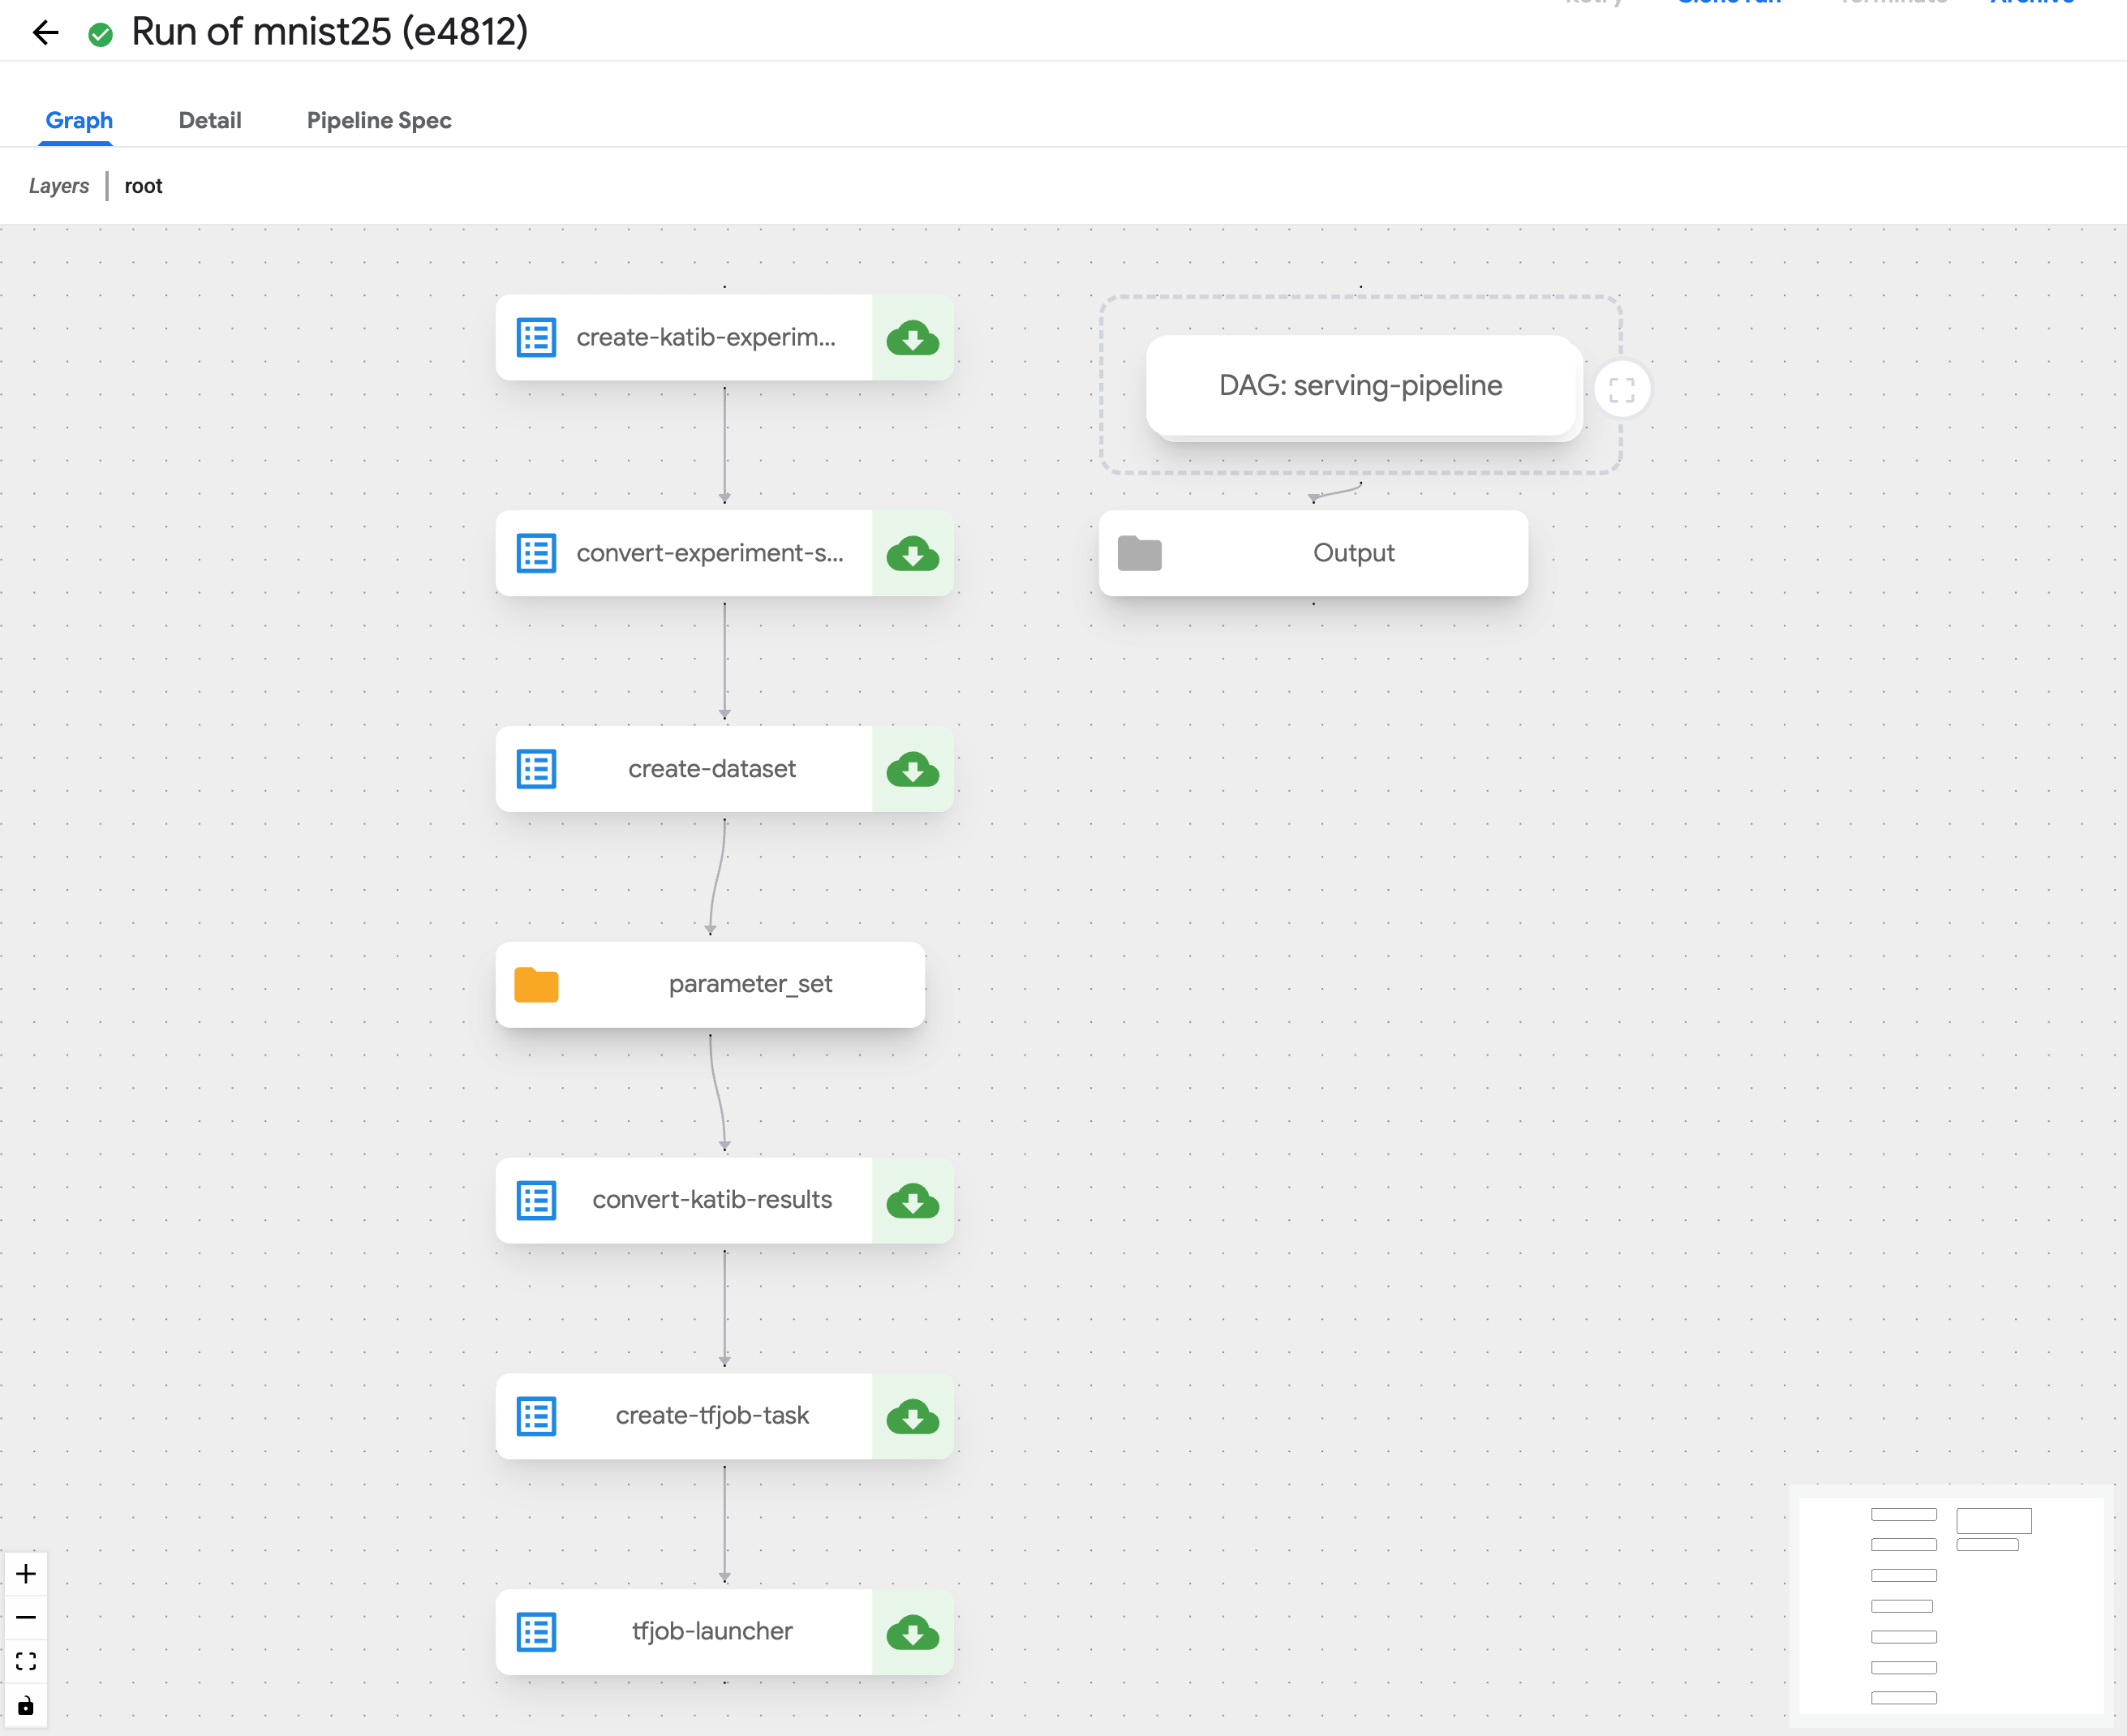

## Predict from the trained model

Once Kubeflow Pipeline is finished, you are able to call the API endpoint with [mnist image](https://raw.githubusercontent.com/kubeflow/katib/master/examples/v1beta1/kubeflow-pipelines/images/9.bmp) to predict from the trained model.

**Note**: If you are using Kubeflow + Dex setup and runing this Notebook outside of your Kubernetes cluster, follow [this guide](https://github.com/kserve/kserve/tree/master/docs/samples/istio-dex#authentication) to get Session ID for the API requests.

In [ ]:
import numpy as np
from PIL import Image
import requests


# Due to [issue #8300](https://github.com/kubeflow/pipelines/issues/8300), 
# connecting to Kubeflow Pipelines using PodDefaults is not working for now. You can still use the Kubeflow Dashboard to upload pipeline and create run.

# Pipeline Run should be succeeded.
# kfp_run = kfp_client.get_run(run_id=run_id)
# if kfp_run.run.status != "Succeeded":
#     print("Run {} is not Succeeded\n".format(run_id))
#     import os
#     os._exit(os.EX_OK)


# Specify the image URL here.
image_url = "https://raw.githubusercontent.com/kubeflow/katib/master/examples/v1beta1/kubeflow-pipelines/images/9.bmp"
image = Image.open(requests.get(image_url, stream=True).raw)
data = np.array(image.convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)
data_formatted = np.array2string(data, separator=",", formatter={"float": lambda x: "%.1f" % x})
json_request = '{{ "instances" : {} }}'.format(data_formatted)

# Specify the prediction URL. If you are runing this notebook outside of Kubernetes cluster, you should set the Cluster IP.
url = "http://{}-predictor-default.{}.svc.cluster.local/v1/models/{}:predict".format(name, namespace, name)
response = requests.post(url, data=json_request)

print("Prediction for the image")
display(image)
print(response.json())